In [1]:
## Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.ar_model import AR
#from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from scipy import stats
from scipy.stats import normaltest

from sklearn.metrics import mean_squared_error

import warnings
from IPython.display import clear_output

In [2]:
## Load data and convert datatypes
data = pd.read_csv("./data/train.csv")
data['date'] = pd.to_datetime(data['date'])

## Split into train and testing data
## Use the last 3 month (Oct-Dec 2017) as testing data. The rest is training data.
train = data.loc[data['date'] < '2017-10-01' ]
test = data.loc[data['date'] >= '2017-10-01' ]

In [3]:
## Sales for a store and an item
def get_sales(train, test, store, item):
    # Training
    sales_train = train.loc[train['store'] == int(store)].loc[train['item'] == int(item)]
    dates_train = sales_train['date'].dt.strftime('%Y-%m-%d')
    sales_train = sales_train['sales'].tolist()
   
    # Testing 
    sales_test = test.loc[test['store'] == int(store)].loc[test['item'] == int(item)]
    dates_test = sales_test['date'].dt.strftime('%Y-%m-%d')
    sales_test = sales_test['sales'].tolist()
              
    return sales_train, dates_train, sales_test, dates_test

In [4]:
def plot_sales_per_store_item(df, store=1, item=1):
    '''
    Plots predicted sales for a given store and an item.
    Input: Dataframe df with test and predicted values
    '''
    df = df.loc[df['store'] == store]
    df = df.loc[df['item'] == item]
    
    plt.figure(figsize=[20,10])
    
    plt.plot(df['date'].dt.strftime('%Y-%m-%d'), df['sales'], color="navy", label='truth')
    plt.plot(df['date'].dt.strftime('%Y-%m-%d'), df['predicted ARIMA'], color="green", label='prediction')
    plt.title("Prediction and ground truth")
    plt.xticks(np.arange(0, len(df), 10))
    plt.xlabel("Date")
    plt.ylabel("Sales [-]")
    plt.legend()
    plt.show()

### Autoregressive Integrated Moving Average (ARIMA)

In [5]:
## Remove seasonal component in data
def difference(data, interval=365):
    diff = []
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
        
    return np.array(diff)

## Reconstruct seasonality
def inverse_difference(history, yhat, interval=365):
    
    return yhat + history[-interval]

One step out-of-sample forecast

True value: 71
Forecast function: 67.2114895258735 | Predict function: [67.21148953]
Multiple step out-of-sample forecast



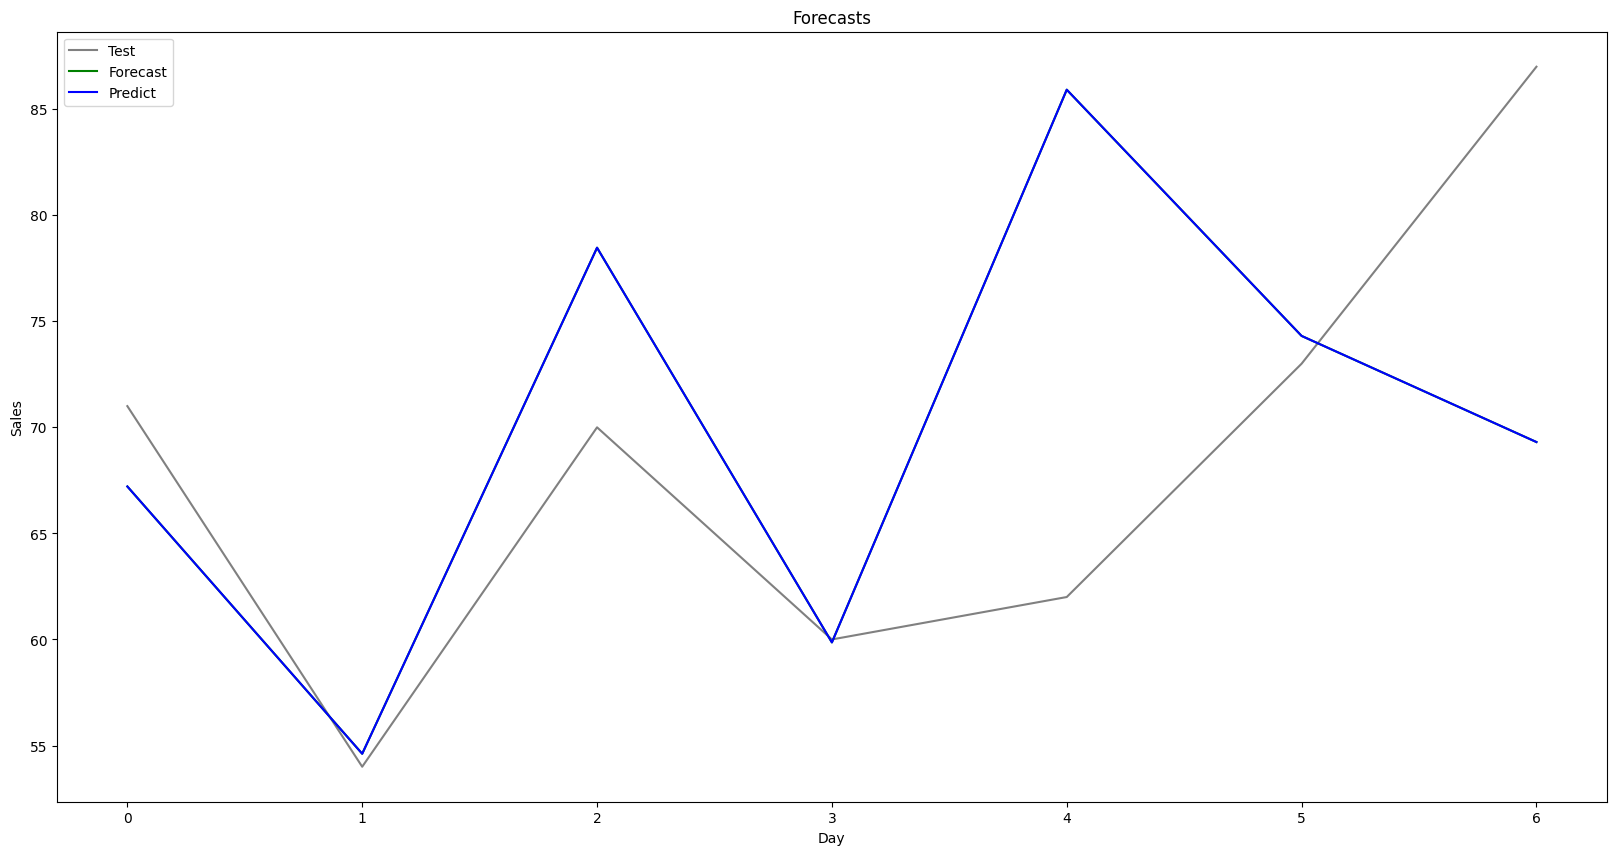

In [6]:
## Get data for store 4 and item 7:
store = 4
item = 7

train_4_7, dates_train, test_4_7, dates_test = get_sales(train, test, store, item)

## Remove seasonal component in data
differenced = difference(train_4_7, 365)

## Fit model with arbitray order
model = ARIMA(differenced, order=(7, 0, 1))
model_fit = model.fit()

## Predictions
print("=============================\nOne step out-of-sample forecast\n")
### 1. One step out-of-sample forecasts
##### Forecast function
forecast = model_fit.forecast()[0]
forecast = inverse_difference(train_4_7, forecast, 365)

#### Predict function
start = len(differenced)
end = len(differenced)
prediction = model_fit.predict(start, end)
prediction = inverse_difference(train_4_7, prediction, 365)

print("True value: {}\nForecast function: {} | Predict function: {}".format(test_4_7[0], forecast, prediction))
print("=============================\nMultiple step out-of-sample forecast\n")

### 2. Multiple step out-of-sample forecast
#### Forecast function
days = 7

forecast = model_fit.forecast(steps=days)

history = [x for x in train_4_7]
day = 1
for yhat in forecast:
    inverted = inverse_difference(history, yhat, 365)
    history.append(inverted)
    day +=1

#### Predict function
start = len(differenced)
end = start + days-1

prediction = model_fit.predict(start, end)

history_pred = [x for x in train_4_7]
day = 1
for yhat in prediction:
    inverted = inverse_difference(history_pred, yhat, 365)
    history_pred.append(inverted)
    day +=1

## Plots
plt.figure(figsize=[20,10])
plt.title("Forecasts")
plt.plot(test_4_7[:days], color='grey', label='Test')
plt.plot(history[-days:], color='green', label='Forecast')
plt.plot(history_pred[-days:], color='blue', label='Predict')
plt.xlabel("Day")
plt.ylabel("Sales")
plt.legend()
plt.show()

In [7]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1369
Model:                 ARIMA(7, 0, 1)   Log Likelihood               -5540.838
Date:                Thu, 13 Oct 2022   AIC                          11101.676
Time:                        20:19:26   BIC                          11153.894
Sample:                             0   HQIC                         11121.218
                               - 1369                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5021      0.515      8.747      0.000       3.493       5.511
ar.L1         -0.1990      0.061     -3.276      0.001      -0.318      -0.080
ar.L2         -0.0172      0.027     -0.646      0.519      -0.069       0.035
ar.L3         -0.0430      0.025     -1.744      0.081      -0.091       0.005
ar.L4         -0.0158      0.025     -0.628      0.530      -0.065       0.033
ar.L5          0.0529      0.025      2.132      0.033       0.004       0.102
ar.L6         -0.0713      0.026     -2.786      0.005      -0.121      -0.021
ar.L7          0.4213      0.025     16.689      0.000       0.372       0.471
ma.L1          0.1481      0.064      2.326      0.020       0.023       0.273
sigma2       191.6270      7.461     25.685      0.000     177.005     206.249
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.85
Prob(Q):                              0.96   Prob(JB):                         0.05
Heteroskedasticity (H):               1.28   Skew:                            -0.16
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Parameter Optimization

In [8]:

def evaluate_arima_model(train, test, arima_order):
    '''
    Evaluate an ARIMA model of order (p, d, q).
    Returns the MSE.
    '''
    ## Remove seasonal components (year scale)    
    history = [x for x in train]   
    predictions = []
   
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()          
        yhat = model_fit.forecast()[0]         
        predictions.append(yhat)
        history.append(test[t])
        
    error = mean_squared_error(test, predictions)
    
    return error


def evaluate_models(train, test, p_values, d_values, q_values):
    '''
    Grid search on ARIMA models.
    Prints out the best parameter setting.
    '''
    #print(train_4_7, dates_train, test_4_7, dates_test)
    mse=0
    train = np.array(train).astype('float32')
    test = np.array(test).astype('float32')
    
    best_score, best_config = float('inf'), None
    
    for p in p_values:      
        for d in d_values:            
            for q in q_values:
                order = (p,d,q)           
                try:
                    mse = evaluate_arima_model(train, test, order)
                    if mse < best_score:
                        best_score, best_config = mse, order
                        
                    print('ARIMA order: {} | MSE: {:.4f}'.format(order, mse))                 
                
                except Exception as e:
                    print(e)
                    continue
    
    print("\n-----------------------------\nBest ARIMA order: {} | Best MSE: {}".format(best_config, mse))

In [9]:
## Grid search for a store and an item
store = 4
item = 7

## Grid parameters
p_values = [6, 7, 8]
d_values = [1]
q_values = [0, 2, 3, 4]

## Get data for a store and an item
train_4_7, dates_train, test_4_7, dates_test = get_sales(train, test, store, item)
#print(train_4_7, dates_train, test_4_7, dates_test)
warnings.filterwarnings("ignore")
evaluate_models(train_4_7, test_4_7, p_values, d_values, q_values)

ARIMA order: (6, 1, 0) | MSE: 124.5684
ARIMA order: (6, 1, 2) | MSE: 125.7713
ARIMA order: (6, 1, 3) | MSE: 123.2509
ARIMA order: (6, 1, 4) | MSE: 123.0180
ARIMA order: (7, 1, 0) | MSE: 125.9871
ARIMA order: (7, 1, 2) | MSE: 126.2365
ARIMA order: (7, 1, 3) | MSE: 126.6988
ARIMA order: (7, 1, 4) | MSE: 122.9881
ARIMA order: (8, 1, 0) | MSE: 125.8473
ARIMA order: (8, 1, 2) | MSE: 121.3025
ARIMA order: (8, 1, 3) | MSE: 126.1570
ARIMA order: (8, 1, 4) | MSE: 119.6136

-----------------------------
Best ARIMA order: (8, 1, 4) | Best MSE: 119.61361849354736


#### Forecast with the best model

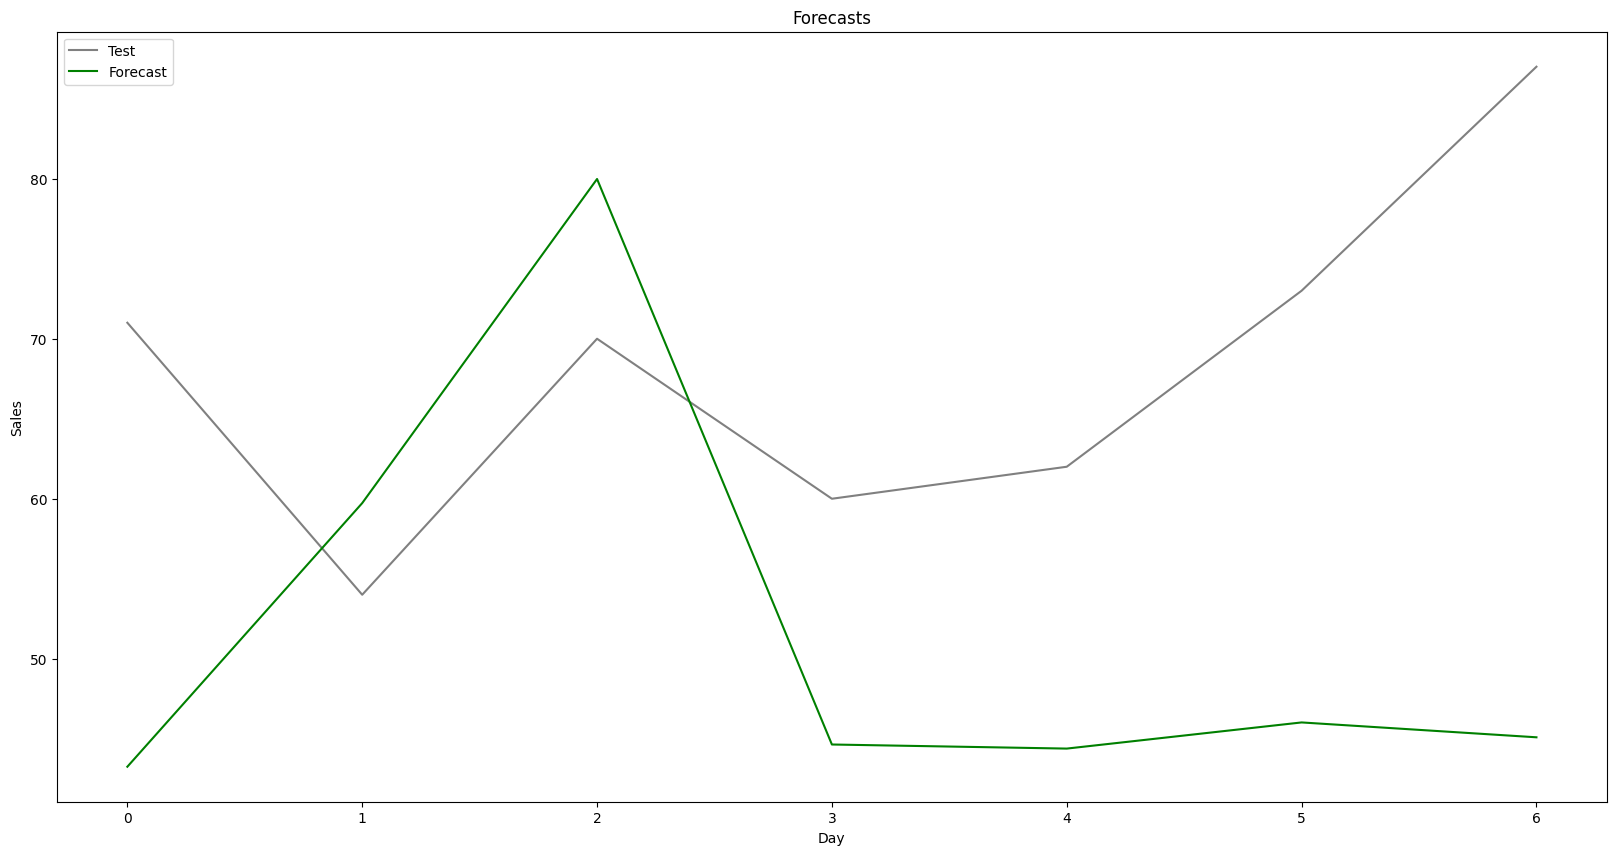

In [10]:
## Forecast with best model
train_4_7, dates_train, test_4_7, dates_test = get_sales(train, test, store, item)

def predict_arima(train_4_7, dates_train, test_4_7, dates_test):
    days = 90
    store = 1
    item = 15
    arima_order = (8,1,3)


    ## Get data for a store and an item:
    
    differenced = difference(train_4_7, 365)

    ## Fit model
    model = ARIMA(differenced, order=arima_order)
    model_fit = model.fit()

    ## Predict
    forecast = model_fit.forecast(steps=days)

    history = [x for x in train_4_7]
    day = 1
    for yhat in forecast:
        inverted = inverse_difference(history, yhat, 365)
        history.append(inverted)
        day +=1
    
    return history
 
arima_res = predict_arima(train_4_7, dates_train, test_4_7, dates_test)


## Plot
plt.figure(figsize=[20,10])
plt.title("Forecasts")
plt.plot(test_4_7[:days], color='grey', label='Test')
plt.plot(arima_res[-days:], color='green', label='Forecast')
plt.xlabel("Day")
plt.ylabel("Sales")
plt.legend()
plt.show()

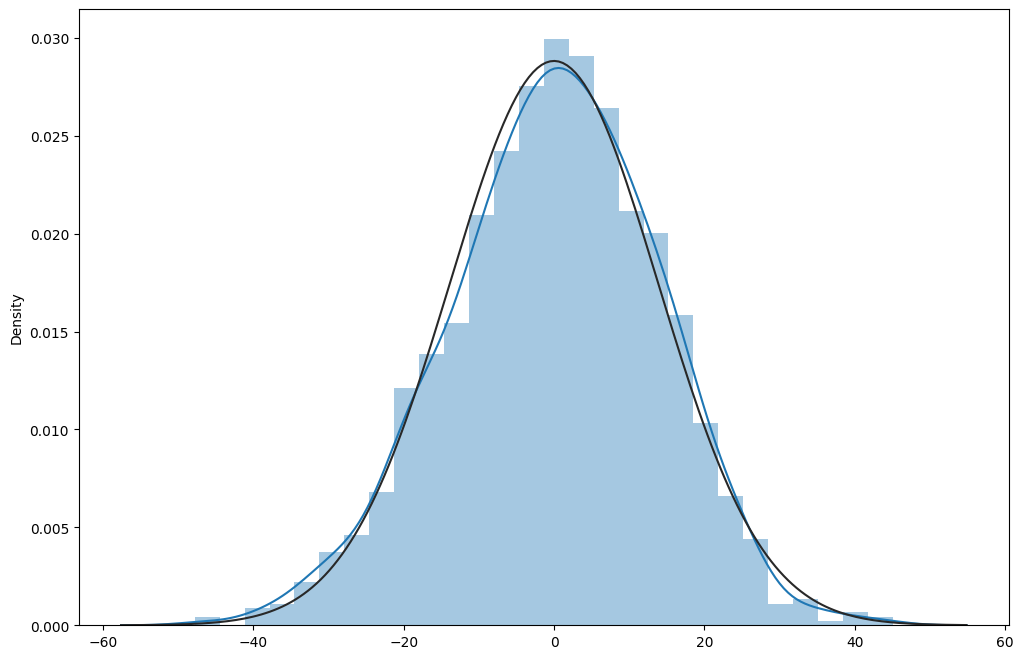

In [11]:
fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(model_fit.resid ,fit = stats.norm, ax = ax0)
plt.show()

In [12]:
### All sales

def predict_all_arima(data):
    '''
    Predictions for all combinations of stores and items.
    Reads the dataframe for tests.
    Outputs the dataframe in plus the predicted sales.
    '''
  
    ## Initialize dataframe for output
    cols = ["date", "store", "item", "sales"]
    df_out = pd.DataFrame()
    
    ## Steps slice data
    stores = list(np.arange(1, 11))
    items = list(np.arange(1, 51))

    for store in stores:
        data_store = data.loc[data['store'] == store]
        
        for item in items:
            predictions = []
            clear_output(wait=True)
            print("Processing store {}/{} and item {}/{}".format(store, stores[-1], item, items[-1]))
            
            data_store_item = data_store.loc[data_store['item'] == item]
         
            train = data_store_item.loc[data_store_item['date'] < '2017-10-01' ]
            test = data_store_item.loc[data_store_item['date'] >= '2017-10-01' ]
            
            train_store_item, dates_train, test_store_item, dates_test = get_sales(train, test, store, item)
            
            
            ## Use model for prediction        
            # ARIMA parameters
            days = len(test_store_item)
            arima_order = (8,1,3)
            
            # Remove seasonal component
            differenced = difference(train_store_item, 365)

            # Fit model
            model = ARIMA(differenced, order=arima_order)
            model_fit = model.fit()

            # Predict
            forecast = model_fit.forecast(steps=days)

            history = [x for x in train_store_item]
            day = 1
            for yhat in forecast:
                inverted = inverse_difference(history, yhat, 365)
                #history.append(inverted)
                predictions.append(inverted)
                day +=1
                  
            ## Add prediction to output dataframe
            
            test["predicted ARIMA"] = predictions           
            df_out = df_out.append(test, ignore_index=True)
    
    ## Generate and save output 
    df_out.to_csv("Predictions_ARIMA.csv")
    print("Done!")

    return df_out

## Predict
data = pd.read_csv("./data/train.csv")
data['date'] = pd.to_datetime(data['date'])
df_arima = predict_all_arima(data)

Processing store 10/10 and item 50/50
Done!


In [46]:
#print(df_arima)
def smape(actual, forecast):
    return 100 / len(actual) * np.sum(2 * np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast)))

error = smape(test.sales,df_arima.predicted ARIMA)
print("SMAPE: " + str(error))


SMAPE: 3.0464162576179916


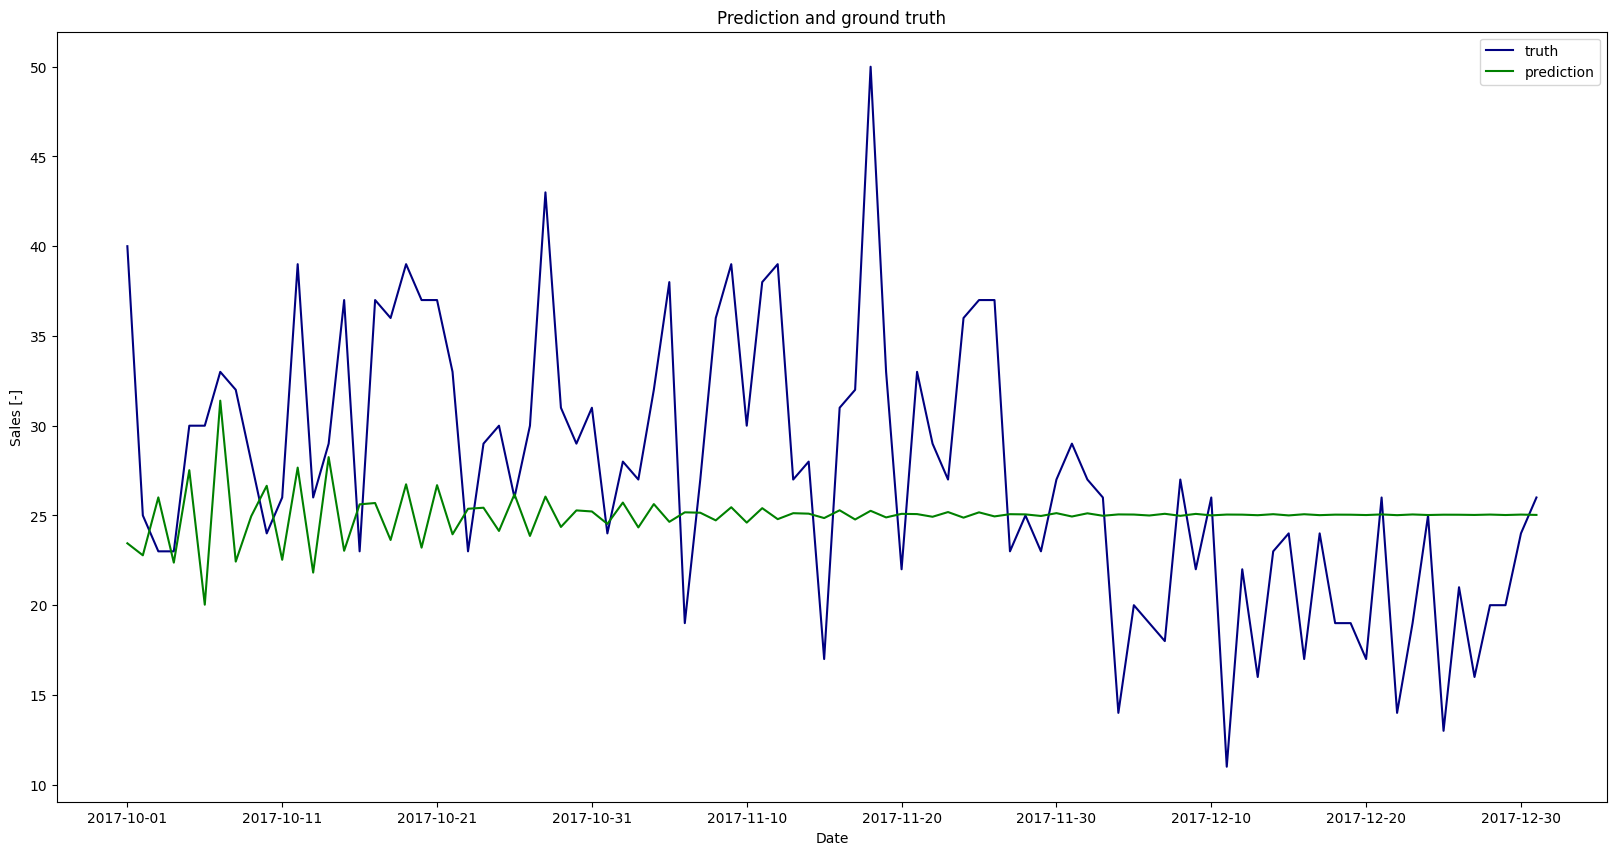

In [22]:
plot_sales_per_store_item(df_arima, 8, 4)